# Setup

This section is for setup, imports, loading data, etc., that is needed prior to modeling. Please do not grade it :)

#### Model Controls

In [1]:
RUN_GRID_SEARCH_CV = False

#### Base Library Imports

In [2]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
%matplotlib inline



#### Load Data

In [3]:
df = pd.read_csv('../../../data/cardio_train.csv', delimiter=';')
# set id as index
df.set_index("id", inplace=True)
# copy original data
df_clean = df.copy(deep=True)
# drop duplicates
df_clean.drop_duplicates(inplace=True)

#### Transformations

In [4]:
# %%time

# Convert age into years
df_clean['age'] = (df_clean['age'] / 365).round().astype('int')

# re-encode gender to 1 (male) and 0 (female)
df_clean['gender'] = np.where((df_clean.gender == 2), 1, 0)

# compute the body mass index based on weight and height
df_clean['bmi'] = df_clean['weight'] / (df_clean['height']/100)**2

# create a BMI group
df_clean['bmiGrp'] = np.where((df_clean.bmi < 18.5), 1, 0)
df_clean['bmiGrp'] = np.where((df_clean.bmi >= 18.5) & (df_clean.bmi < 25), 2, df_clean.bmiGrp)
df_clean['bmiGrp'] = np.where((df_clean.bmi >= 25) & (df_clean.bmi < 30), 3, df_clean.bmiGrp)
df_clean['bmiGrp'] = np.where((df_clean.bmi >= 30), 4, df_clean.bmiGrp)

# bin blood pressure groups based on the api hi/ lo variables
df_clean['bp'] = np.where((df_clean.ap_hi < 120) & (df_clean.ap_lo < 80), 1, 0)
df_clean['bp'] = np.where((df_clean.ap_hi >= 120) & (df_clean.ap_hi < 130) & (df_clean.ap_lo < 80), 2, df_clean.bp)
df_clean['bp'] = np.where((df_clean.ap_hi >= 130) & (df_clean.ap_hi < 140) | ((df_clean.ap_lo >= 80) & (df_clean.ap_lo < 90)), 3, df_clean.bp)
df_clean['bp'] = np.where((df_clean.ap_hi >= 140) | (df_clean.ap_lo >= 90), 4, df_clean.bp)
df_clean['bp'] = np.where((df_clean.ap_hi > 180) | (df_clean.ap_lo > 120), 5, df_clean.bp)



In [5]:
# Full Model
# X_cols = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

# New Feature Model
X_cols = ['age', 'gender', 'bmiGrp', 'bp', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

# Store feature matrix 
X = df_clean[X_cols] #.to_numpy()
# Store response vector
y = df_clean['cardio'] #.to_numpy()



# Create Models (50 points)

Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 



In [6]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline

# Estimators
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import time

## PipeLine and Cross Validation

The below tests 3 classifiers with default parameters. We are not yet doing a grid search here, just default parameters.
* Logistic Regression
* SGD (Stochastic Graident Descent)
* Full SVC

Models consisting of all original and new features with standardized values. RobustScaler below will scale features using statistics that are robutst to outliers.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

Need to make a comment about OHE, and the rational for keeping them numeric (the order of the values are supposed to have meaning)

Note, the below has cv=2 since it includes the SVC classifier. Changing it to 10 will take a bit of time to run!

In [7]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
    test_size=0.2,
    random_state=1,
    stratify=y)

numeric_features = ['age', 'cholesterol', 'bp', 'bmiGrp', 'gluc']
categorical_features = ['gender', 'smoke', 'alco', 'active']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median"))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf1 = LogisticRegression(random_state=1)
clf2 = SGDClassifier(random_state=1)
clf3 = SVC(random_state=1)

pipe1 = Pipeline([['preprocessor', preprocessor], 
                 ['rs', RobustScaler()],
                 ['clf', clf1]])

pipe2 = Pipeline([['preprocessor', preprocessor], 
                  ['rs', RobustScaler()],
                  ['clf', clf2]])
                  
pipe3 = Pipeline([['preprocessor', preprocessor], 
                  ['rs', RobustScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic Regression', 'SGD', 'SVC']

# Note n_jobs below. Setting it to -1 will create cv number of threads
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, pipe2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=2,
                             scoring='roc_auc',
                             n_jobs=-1)
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))


10-fold cross validation:

ROC AUC: 0.77 (+/- 0.00) [Logistic Regression]
ROC AUC: 0.77 (+/- 0.00) [SGD]
ROC AUC: 0.77 (+/- 0.00) [SVC]


Above we can see the preformance of each model is practically identical. There are many different parameters one could tweak and obtain different results. For exmaple, we could try StandardScalar vs RobustScaler. We could also try not One Hot Encoding (OHE) things like cholesterol, since the numbering has an order to it. So one could argue OHE is not needed here.

Other things we can vary are the actual tuning parameters for each of the models. This is where Grid Search comes in.

### TO DO!!
Outline here in detail what each test in the grid is doing ...


## Grid Search

In [8]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
    test_size=0.2,
    random_state=1,
    stratify=y)

numeric_features = ['age', 'cholesterol', 'bp', 'bmiGrp', 'gluc']
categorical_features = ['gender', 'smoke', 'alco', 'active']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median"))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf1 = LogisticRegression(random_state=1)
clf2 = SGDClassifier(n_jobs=-1, random_state=1)
clf3 = LinearSVC(random_state=1)
clf4 = SVC(random_state=1)

pipe1 = Pipeline([['preprocessor', preprocessor], 
                 ['rs', RobustScaler()],
                 ['logistic', clf1]])

pipe2 = Pipeline([['preprocessor', preprocessor], 
                 ['rs', RobustScaler()],
                 ['sgd', clf2]])

pipe3 = Pipeline([['preprocessor', preprocessor], 
                 ['rs', RobustScaler()],
                 ['linear_svc', clf3]])

pipe4 = Pipeline([['preprocessor', preprocessor], 
                 ['rs', RobustScaler()],
                 ['svc', clf4]])

model_params = {
    "logistic_regression": {
        "model": pipe1,
        "params": {
            "logistic__C": [.01, .1, 1, 5, 10, 25, 50],
            "logistic__penalty": ['l1','l2']
        }
    },
    "sgd": {
        "model": pipe2,
        "params": {
            "sgd__alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1],
            "sgd__loss": ['hinge','log'],
            "sgd__class_weight": ["balanced", None],
            "sgd__penalty": ['l1','l2']
        }
    },
    "linear_svc": {
        "model": pipe3,
        "params": {
            "linear_svc__C": [.01, .1, 1, 5, 10, 25, 50],
            "linear_svc__penalty": ['l1','l2'],
            "linear_svc__loss": ['hinge','squared_hinge']
        }
    },
    "svc": {
        "model": pipe4,
        "params": [
            {'svc__kernel': ['linear'], 'svc__C': [1, 10]},
            {'svc__kernel': ['rbf'], 'svc__C': [1, 10], 'svc__gamma': [0.001, 0.0001]},
        ]
    }
}

scores = []

for model_name, mp in model_params.items():
    start = time.time()
    clf = GridSearchCV(estimator = mp["model"], param_grid=mp["params"], cv=2, scoring="roc_auc", n_jobs=-1)
    clf.fit(X_train, y_train)
    elapsed_time = (time.time() - start)

    scores.append({"Model": model_name,
    "Best Score": clf.best_score_, # Mean cross-validated score of the best_estimator
    "Best Params": clf.best_params_,
    "results": clf.cv_results_,
    "Cross Validation Time": elapsed_time
    })

In [9]:
# Although not pretty, it's quick and easy to read
print('10 Fold Cross Validation Scores:')

for model in scores:
    print()
    for key, value in model.items():
        if key == 'results':
            print('Mean Fit Time: ', value['mean_fit_time'].mean())
            print('Mean Score Time: ', value['mean_score_time'].mean())
        else:
            print(key,': ',value)

10 Fold Cross Validation Scores:

Model :  logistic_regression
Best Score :  0.7692737629549344
Best Params :  {'logistic__C': 0.01, 'logistic__penalty': 'l2'}
Mean Fit Time:  0.12293681928089686
Mean Score Time:  0.02354644877570016
Cross Validation Time :  1.2726397514343262

Model :  sgd
Best Score :  0.770305923768533
Best Params :  {'sgd__alpha': 0.1, 'sgd__class_weight': 'balanced', 'sgd__loss': 'log', 'sgd__penalty': 'l2'}
Mean Fit Time:  0.3042753547430038
Mean Score Time:  0.05135035812854767
Cross Validation Time :  2.90891432762146

Model :  linear_svc
Best Score :  0.7692188002423259
Best Params :  {'linear_svc__C': 1, 'linear_svc__loss': 'hinge', 'linear_svc__penalty': 'l2'}
Mean Fit Time:  1.258601073707853
Mean Score Time:  0.02149665355682373
Cross Validation Time :  9.651350259780884

Model :  svc
Best Score :  0.7758775085860634
Best Params :  {'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Mean Fit Time:  80.89608198404312
Mean Score Time:  22.3182265758514

# Model Advantages (10)

Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

### To DO
All of the models ran have a similar score. However, the time to run the models varies significantly. Logistic Regression is much faster .... <TO DO> add SVC, Explain why SGD is faster than linear SVC.

# Interpret Feature Importance (30)

Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

Let's rerun a logist regression model using the best params found above via GridSearch.

In [10]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
    test_size=0.2,
    random_state=1,
    stratify=y)

numeric_features = ['age', 'cholesterol', 'bp', 'bmiGrp', 'gluc']
categorical_features = ['gender', 'smoke', 'alco', 'active']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median"))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

logreg = LogisticRegression(penalty='l2',
                          C=.01,
                          random_state=1)

pipe1 = Pipeline([['preprocessor', preprocessor], 
                 ['rs', RobustScaler()],
                 ['logistic', logreg]])

fit = pipe1.fit(X_train, y_train)

In [11]:
# https://stackoverflow.com/questions/57528350/can-you-consistently-keep-track-of-column-labels-using-sklearns-transformer-api/57534118#57534118
def get_transformer_feature_names(columnTransformer):

    output_features = []

    for name, pipe, features in columnTransformer.transformers_:
        if name!='remainder':
            for i in pipe:
                trans_features = []
                if hasattr(i,'categories_'):
                    trans_features.extend(i.get_feature_names(features))
                else:
                    trans_features = features
            output_features.extend(trans_features)

    return output_features

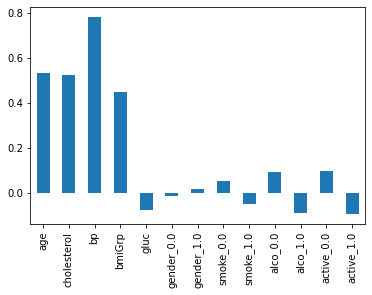

In [12]:
weightNames = get_transformer_feature_names(pipe1['preprocessor'])
weights = pd.Series(pipe1['logistic'].coef_[0], index=weightNames)
weights.plot(kind='bar')

The above graph shows the weights of the features for Logistic Regression. From this graph, we can clearly see that the features that contribute signficantly to the model are Age, Cholesterol, Blood Pressure and the BMI Group. Other attributes, like Gender, Smoking, Alcohol and Activity don't appear to contribute as much.

It makes sense that cholestorel, blood pressure and bmi and age would contribute signficantly to the model. Let's rerun Logist regression with just these 4 features and see how the model changes.

In [13]:
# New Feature Model
X_cols_reduced = ['age', 'cholesterol', 'bp', 'bmiGrp']

# Store feature matrix 
X_reduced = df_clean[X_cols_reduced] #.to_numpy()
# Store response vector
y_reduced = df_clean['cardio'] #.to_numpy()

X_train, X_test, y_train, y_test =\
    train_test_split(X_reduced, y_reduced,
    test_size=0.2,
    random_state=1,
    stratify=y)

numeric_features = ['age', 'cholesterol', 'bp', 'bmiGrp']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median"))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

logreg = LogisticRegression(penalty='l2',
                          C=.01,
                          random_state=1)

pipe1 = Pipeline([['preprocessor', preprocessor], 
                 ['rs', RobustScaler()],
                 ['logistic', logreg]])

fit = pipe1.fit(X_train, y_train)

precision    recall  f1-score   support

           0       0.71      0.70      0.70      7001
           1       0.70      0.72      0.71      6995

    accuracy                           0.71     13996
   macro avg       0.71      0.71      0.71     13996
weighted avg       0.71      0.71      0.71     13996



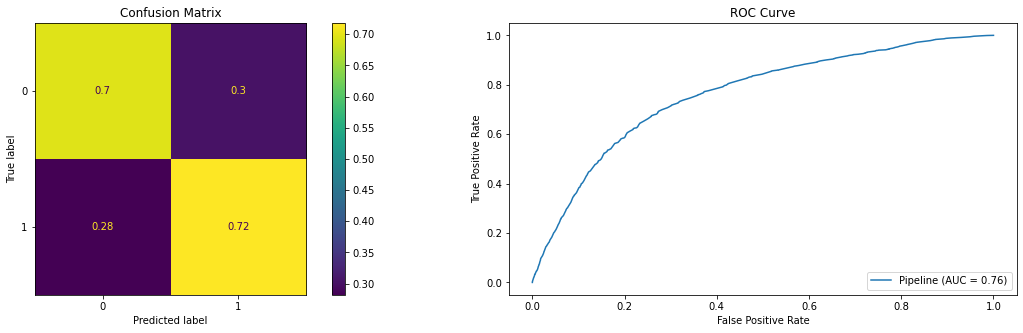

In [14]:
y_pred = fit.predict(X_test)
print(classification_report(y_test, y_pred))

fig = plt.figure(1, figsize=(20, 5))

chart_1 = fig.add_subplot(121)
chart_2 = fig.add_subplot(122)

# Pass Fitted Model, and our test sets, see how they do
plot_confusion_matrix(pipe1, X_test, y_test, normalize='true', ax=chart_1)
chart_1.set_title('Confusion Matrix')

plot_roc_curve(pipe1, X_test, y_test, ax=chart_2)
chart_2.set_title('ROC Curve')

plt.show()

The above shows that the performance of the model with using just 4 features is nearly identical to the full model.

# Interpret Support Vectors (10)

Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.

In [15]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
    test_size=0.2,
    random_state=1,
    stratify=y)

numeric_features = ['age', 'cholesterol', 'bp', 'bmiGrp', 'gluc']
categorical_features = ['gender', 'smoke', 'alco', 'active']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median"))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

svm = SVC(kernel='linear', C=1, random_state=1)

pipe1 = Pipeline([['preprocessor', preprocessor], 
                 ['rs', RobustScaler()],
                 ['svm', svm]])

fit = pipe1.fit(X_train, y_train)

Below we output the support vector information. Our dataset had about 70K records, and below we see that we have about half that number in support vectors. Consistent with what was discussed in class, quoting Dr. Drew "Because the way support vector machines is designed it's only going to pick up, it's only going to make a support vector for either a zeta or slack variable or an instance a training record instance that falls right along the decision boundary. That's the only thing it needs to say to make its decision."

In [16]:
print(svm.support_vectors_.shape)
print(svm.support_.shape)
print(svm.n_support_ )

(38933, 13)
(38933,)
[19469 19464]
